In [36]:
from upscaler.data import load_images_from_dir, downscale_images, convert_image_series_to_array, convert_array_to_image

from keras.models import load_model
from keras.layers import Input
from keras.models import Model
import tensorflow as tf
from tqdm import tqdm_notebook
import os
from PIL import Image

# Images

In [2]:
images = load_images_from_dir(
    '../images/ukiyo-e_fullhd',
    '.jpg',
    limit = 10000,
    prog_func = tqdm_notebook
)

images = downscale_images(
    images,
    prog_func = tqdm_notebook,
    downscale_ratio = 4
)

In [3]:
img_size = images.downscaled[0].size
input_shape = (img_size[1], img_size[0], 3)

# Model

In [4]:
upscaler = load_model('../example_movie_frames/model_upscaler_mini_resnet-att_vgg-only_x4_best.h5', custom_objects = { "tf": tf })

W1116 20:03:47.269724 139924039448384 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1116 20:03:47.308146 139924039448384 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1116 20:03:47.364548 139924039448384 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1116 20:03:47.365178 139924039448384 deprecation_wrapper.py:119] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1

In [5]:
upscaler.layers.pop(0)

In [6]:
input = Input(shape = input_shape, name="initial/modified_input")
output = upscaler(input)
modified_upscaler = Model(input, output)

# Test

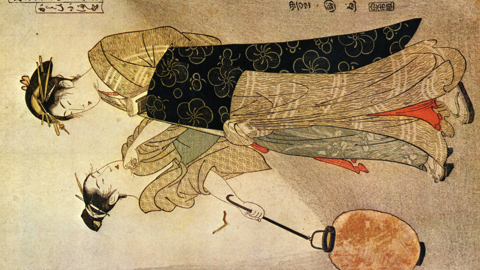

In [7]:
images.downscaled[0]

In [43]:
batch = convert_image_series_to_array([images.downscaled[0]])

In [44]:
upscaled = modified_upscaler.predict(batch)

In [10]:
upscaled_img = convert_array_to_image(upscaled[0,:,:,:])

In [15]:
# upscaled_img

# Recalc all

In [28]:
images.head()

,filename,image_size,image_hr,downscaled
0,0017-courting-komachi-1792.jpg,"(1920, 1080)",<PIL.Image.Image image mode=RGB size=1920x1080...,<PIL.Image.Image image mode=RGB size=480x270 a...
1,0019-portrait-of-naniwaya-okita-1793.jpg,"(1920, 1080)",<PIL.Image.Image image mode=RGB size=1920x1080...,<PIL.Image.Image image mode=RGB size=480x270 a...
2,0021-from-the-series-kasen-koi-no-bu-1794.jpg,"(1920, 1080)",<PIL.Image.Image image mode=RGB size=1920x1080...,<PIL.Image.Image image mode=RGB size=480x270 a...
3,0022-hour-of-the-snake-1794.jpg,"(1920, 1080)",<PIL.Image.Image image mode=RGB size=1920x1080...,<PIL.Image.Image image mode=RGB size=480x270 a...
4,0024-oiran-hanaogi.jpg,"(1920, 1080)",<PIL.Image.Image image mode=RGB size=1920x1080...,<PIL.Image.Image image mode=RGB size=480x270 a...


In [20]:
image_source = "ukiyo"
prefix = "mini_resnet-att_vgg-only_x4"

output_path = "example_images/" + image_source + "/" + prefix + "/all_hd_images/"

In [21]:
if not os.path.exists(output_path):
    os.makedirs(output_path)

In [48]:
for img_tuple in tqdm_notebook(images.iterrows()):
    img = img_tuple[1]
    filepath = output_path + img.filename.replace(".jpg", "_%s.jpg")
    
    img.image_hr.save(filepath % "orig", quality = 95)
    
    upscaled = img.downscaled.resize(img.image_hr.size, Image.BICUBIC)
    upscaled.save(filepath % "lowres", quality = 95)
    
    upscaled = convert_image_series_to_array([img.downscaled])
    upscaled = modified_upscaler.predict(upscaled)[0]
    upscaled = convert_array_to_image(upscaled)
    upscaled.save(filepath % "upscaled", quality = 95)
    